## Import modules

In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers, backend
from keras import layers, backend
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import keras_cv

### Define Hyperparameters

In [49]:
IMAGE_SIZE = 256
BATCH_SIZE = 4
OUT_CLASSES = 1
TRAIN_SPLIT_RATIO = 0.9
EPOCHS = 5  # You can increase this for better results

# Paths to your Monuseg dataset
IMAGES_DIR = '..\\Dataset\\Images'         # Update with your images directory
ANNOTATIONS_DIR = '..\\Dataset\\Annotations'  # Update with your annotations directory

# Dataset Pre-processing

### Parse the XML Annotations

In [50]:
def create_mask_from_xml(xml_path, image_size):
    """
    Parses an XML annotation file and creates a binary mask.
    
    Parameters:
    - xml_path: Path to the XML annotation file.
    - image_size: Tuple indicating the size of the image (width, height).
    
    Returns:
    - mask_array: A NumPy array representing the binary mask.
    """
    # Create a blank mask image
    mask = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(mask)

    # Parse the XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Iterate over all 'Region' elements
    for region in root.findall('.//Region'):
        vertices = []
        for vertex in region.findall('.//Vertex'):
            x = float(vertex.get('X'))
            y = float(vertex.get('Y'))
            vertices.append((x, y))

        # Draw the polygon on the mask
        if vertices:
            draw.polygon(vertices, outline=1, fill=1)

    # Convert mask to NumPy array
    mask_array = np.array(mask, dtype=np.float32)
    return mask_array

### Load image and mask paths

In [51]:
def load_paths(images_dir, annotations_dir, split_ratio):
    image_paths = sorted(glob(os.path.join(images_dir, '*.*')))
    annotation_paths = sorted(glob(os.path.join(annotations_dir, '*.xml')))

    # Ensure that the number of images and annotations are equal
    assert len(image_paths) == len(annotation_paths), "Mismatch between images and annotations."

    len_ = int(len(image_paths) * split_ratio)
    return (image_paths[:len_], annotation_paths[:len_]), (image_paths[len_:], annotation_paths[len_:])

### Pre-processing function

In [52]:
def preprocess(image_path, annotation_path, img_size, out_classes):
    def f(_image_path, _annotation_path):
        _image_path = _image_path.decode()
        _annotation_path = _annotation_path.decode()

        # Load and preprocess image
        image = Image.open(_image_path).convert('RGB')
        original_size = image.size  # Keep original size for mask creation
        image = image.resize((img_size, img_size))
        image_array = np.array(image, dtype=np.float32) / 255.0  # Normalize to [0, 1]

        # Create mask from XML annotation
        mask = create_mask_from_xml(_annotation_path, original_size)
        mask = Image.fromarray(mask).resize((img_size, img_size))
        mask_array = np.array(mask, dtype=np.float32)
        mask_array = np.expand_dims(mask_array, axis=-1)  # Add channel dimension

        return image_array, mask_array

    image, mask = tf.numpy_function(f, [image_path, annotation_path], [tf.float32, tf.float32])
    image.set_shape([img_size, img_size, 3])
    mask.set_shape([img_size, img_size, out_classes])
    return image, mask

### Dataset processing

In [53]:
def load_dataset(image_paths, annotation_paths, img_size, out_classes, batch_size, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, annotation_paths))
    if shuffle:
        dataset = dataset.cache().shuffle(buffer_size=1000)
    dataset = dataset.map(
        lambda x, y: preprocess(x, y, img_size, out_classes),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Load paths
train_paths, val_paths = load_paths(IMAGES_DIR, ANNOTATIONS_DIR, TRAIN_SPLIT_RATIO)

# Create datasets
train_dataset = load_dataset(
    train_paths[0], train_paths[1], IMAGE_SIZE, OUT_CLASSES, BATCH_SIZE, shuffle=True
)
val_dataset = load_dataset(
    val_paths[0], val_paths[1], IMAGE_SIZE, OUT_CLASSES, BATCH_SIZE, shuffle=False
)

print(f"Train Dataset: {train_dataset}")
print(f"Validation Dataset: {val_dataset}")

Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>


# Visualizing Data

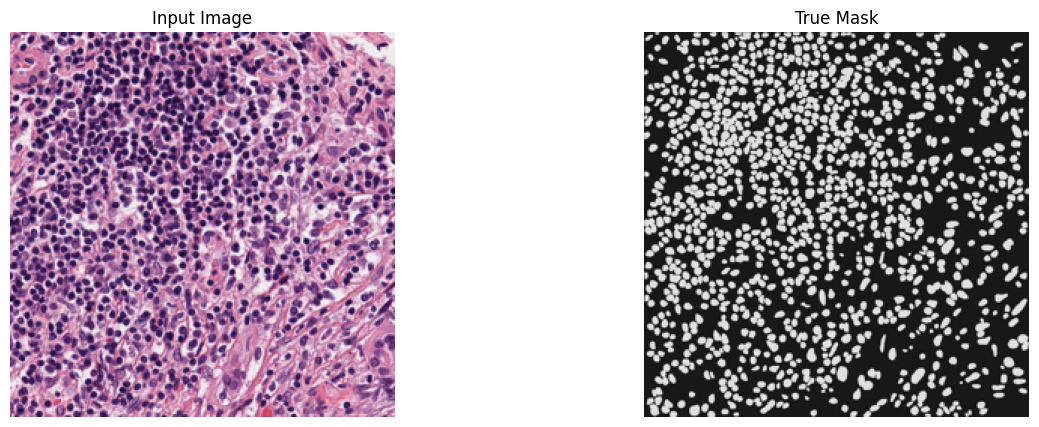

In [54]:
def display(display_list):
    title = ["Input Image", "True Mask", "Predicted Mask"]

    plt.figure(figsize=(15, 5))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
        plt.axis("off")
    plt.show()

# Visualize a sample from the validation dataset
for image, mask in val_dataset.take(1):
    display([image[2], mask[2]])

# Building the BASnet model

### Defining helper functions

In [55]:
def basic_block(x_input, filters, stride=1, down_sample=None, activation=None):
    residual = x_input

    x = layers.Conv2D(filters, (3, 3), strides=stride, padding="same", use_bias=False)(x_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, (3, 3), strides=(1, 1), padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if down_sample is not None:
        residual = down_sample

    x = layers.Add()([x, residual])

    if activation is not None:
        x = layers.Activation(activation)(x)

    return x

def convolution_block(x_input, filters, dilation=1):
    x = layers.Conv2D(filters, (3, 3), padding="same", dilation_rate=dilation)(x_input)
    x = layers.BatchNormalization()(x)
    return layers.Activation("relu")(x)

def segmentation_head(x_input, out_classes, final_size):
    x = layers.Conv2D(out_classes, kernel_size=(3, 3), padding="same")(x_input)
    if final_size is not None:
        x = layers.Resizing(final_size[0], final_size[1])(x)
    return x

### Building the prediction module

In [56]:
def basnet_predict(input_shape, out_classes):
    filters = 64

    x_input = layers.Input(input_shape)

    # Use ResNet50 as the backbone without adding any initial layers
    resnet_base = keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=x_input,
    )

    # Collect outputs from intermediate layers for skip connections
    layer_names = [
        'conv1_relu',       # Stage 1 output
        'conv2_block3_out', # Stage 2 output
        'conv3_block4_out', # Stage 3 output
        'conv4_block6_out', # Stage 4 output
    ]

    encoder_outputs = [resnet_base.get_layer(name).output for name in layer_names]

    x = resnet_base.output  # Output of ResNet50 backbone

    # -------------Bridge-------------
    x = convolution_block(x, filters=filters * 8, dilation=2)
    x = convolution_block(x, filters=filters * 8, dilation=2)
    x = convolution_block(x, filters=filters * 8, dilation=2)
    encoder_outputs.append(x)

    # -------------Decoder-------------
    decoder_blocks = []
    num_stages = len(encoder_outputs)
    for i in reversed(range(num_stages)):
        if i != (num_stages - 1):  # Except first, scale other decoder stages.
            x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)

        x = layers.concatenate([encoder_outputs[i], x], axis=-1)
        x = convolution_block(x, filters=filters * 8)
        x = convolution_block(x, filters=filters * 8)
        x = convolution_block(x, filters=filters * 8)
        decoder_blocks.append(x)

    decoder_blocks.reverse()  # Change order from last to first decoder stage.
    decoder_blocks.append(encoder_outputs[-1])  # Copy bridge to decoder.

    # -------------Side Outputs--------------
    decoder_blocks = [
        segmentation_head(decoder_block, out_classes, input_shape[:2])
        for decoder_block in decoder_blocks
    ]

    return keras.models.Model(inputs=[x_input], outputs=decoder_blocks)

### Building the residual refinement module

In [57]:
def basnet_rrm(base_model, out_classes):
    num_stages = 4
    filters = 64

    x_input = base_model.output[0]

    # -------------Encoder--------------
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(x_input)

    encoder_blocks = []
    for _ in range(num_stages):
        x = convolution_block(x, filters=filters)
        encoder_blocks.append(x)
        x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    # -------------Bridge--------------
    x = convolution_block(x, filters=filters)

    # -------------Decoder--------------
    for i in reversed(range(num_stages)):
        shape = keras.backend.int_shape(x)
        x = layers.Resizing(shape[1] * 2, shape[2] * 2)(x)
        x = layers.concatenate([encoder_blocks[i], x], axis=-1)
        x = convolution_block(x, filters=filters)

    x = segmentation_head(x, out_classes, None)  # Segmentation head.

    # ------------- refined = coarse + residual
    x = layers.Add()([x_input, x])  # Add prediction + refinement output

    # Return the model without wrapping the output tensor in a list
    return keras.models.Model(inputs=[base_model.input], outputs=x)

### Combining prediction and refinement module

In [58]:
def basnet(input_shape, out_classes):
    # Prediction model
    predict_model = basnet_predict(input_shape, out_classes)

    # Refinement model
    refine_model = basnet_rrm(predict_model, out_classes)

    # Output only the refined output
    output = refine_model.output  # Now a tensor, not a list

    # Apply sigmoid activation
    output = layers.Activation("sigmoid")(output)

    # Return the final model
    return keras.models.Model(inputs=[predict_model.input], outputs=output)

# Defining the hybrid loss function

In [59]:
class BasnetLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super(BasnetLoss, self).__init__(name="basnet_loss", **kwargs)
        self.smooth = 1e-9
        self.cross_entropy_loss = keras.losses.BinaryCrossentropy()

    def calculate_iou(self, y_true, y_pred):
        intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
        union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection
        return tf.reduce_mean((intersection + self.smooth) / (union + self.smooth), axis=0)

    def call(self, y_true, y_pred):
        # Print shapes for debugging
        tf.print("y_true shape:", tf.shape(y_true))
        tf.print("y_pred shape:", tf.shape(y_pred))

        cross_entropy_loss = self.cross_entropy_loss(y_true, y_pred)
        ssim_value = tf.image.ssim(y_true, y_pred, max_val=1.0)
        ssim_loss = tf.reduce_mean(1 - ssim_value + self.smooth, axis=0)
        iou_value = self.calculate_iou(y_true, y_pred)
        iou_loss = 1 - iou_value
        return cross_entropy_loss + ssim_loss + iou_loss

# Compiling the model

In [60]:
basnet_model = basnet(input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3], out_classes=OUT_CLASSES)
basnet_model.summary()

optimizer = keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8)
basnet_model.compile(
    loss=BasnetLoss(),
    optimizer=optimizer,
    metrics=[keras.metrics.MeanAbsoluteError(name="mae")],
)

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 84,578,690 (322.64 MB)

 Trainable params: 84,505,986 (322.36 MB)

 Non-trainable params: 72,704 (284.00 KB)

# Train the model

In [61]:
history = basnet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
)

Epoch 1/5


c:\Users\Supriya Deb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['keras_tensor_1172']]. Received: the structure of inputs=*
  warnings.warn(


y_true shape: [4 256 256 1]
y_pred shape: [4 256 256 1]
1/9 ━━━━━━━━━━━━━━━━━━━━ 11:47 88s/step - loss: 2.6872 - mae: 0.4952y_true shape: [4 256 256 1]
y_pred shape: [4 256 256 1]


KeyboardInterrupt: 

# Visualize prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


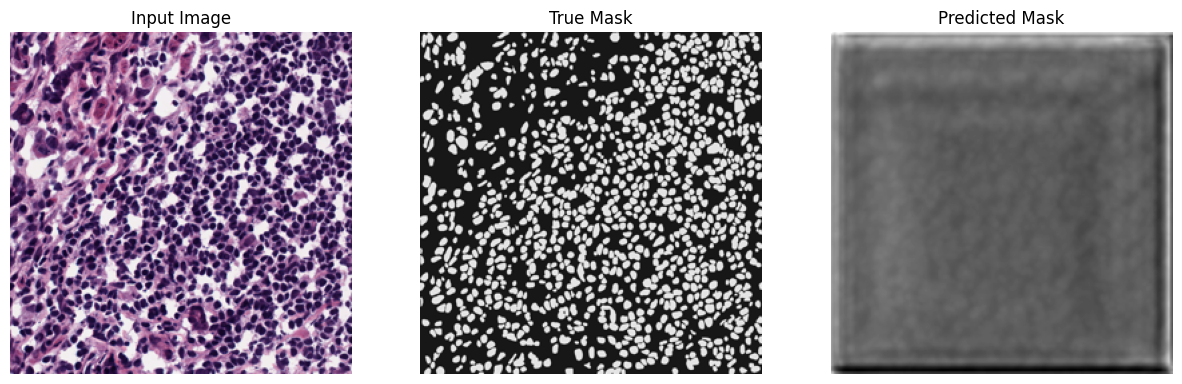

In [33]:
def normalize_output(prediction):
    max_value = np.max(prediction)
    min_value = np.min(prediction)
    return (prediction - min_value) / (max_value - min_value)

# Make predictions on the validation dataset
for image, mask in val_dataset.take(1):
    pred_mask = basnet_model.predict(image)
    display([image[0], mask[0], normalize_output(pred_mask[0])])